# Libraries

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import os
import csv
import sys

import scipy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sbn

import scanpy as sc
import anndata

In [3]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

json==2.0.9
numpy==1.22.3
pandas==1.5.3
csv==1.0
scipy==1.7.3
scanpy==1.9.3
scvelo==0.2.5
seaborn==0.12.2
sklearn==1.2.2
anndata==0.9.1
cellrank==1.5.1
networkx==2.8.4
matplotlib==3.7.2
re==2.2.1


In [4]:
cell_cycle_genes_path = '/mnt/g/My Drive/Python/Projects/regev_lab_cell_cycle_genes.txt'

cell_cycle_genes = [x.strip().title() for x in open(cell_cycle_genes_path)]

# Separate dataset for S-phase or G2M-phase associated genes
s_genes = [x for x in cell_cycle_genes[:43]]
g2m_genes = [x for x in cell_cycle_genes[43:]]

# Read in data

In [5]:
path = '/mnt/g/My Drive/MKA/Papers/Ezhkova TD_Seq'
seq = pd.read_table(os.path.join(path, '201512281816_expression_counts.txt'), index_col = 0).T
meta = pd.read_table(os.path.join(path, '201512281816_meta_TD.txt'), index_col = 0).T
clusters = pd.read_table(os.path.join(path, '201512281816_s_groups_TD.txt'), header = None, index_col = 0)

In [6]:
adata = anndata.AnnData(X = seq, obs = meta)
adata.obs['clusters'] = [int(clusters.loc[name, 1]) if name in clusters.index else np.nan for name in adata.obs_names]
adata.obs['clusters'] = adata.obs['clusters'].fillna('??')
adata.obs['clusters'] = adata.obs['clusters'].astype('category')
adata.X = scipy.sparse.csr_matrix(adata.X)
adata

AnnData object with n_obs × n_vars = 227 × 24487
    obs: 'Chip serial number', 'Chip type', 'Date of Run', 'Species', 'Tissue/cell type/source', 'Principal Investigator', 'Scientist', 'Operator', 'Protocol', 'Comments', 'experiment_number', 'mouse_number', 'strain', 'gender', 'breeder', 'date_of_birth', 'age', 'weight', 'time_of_death', 'date', 'attached_chip_number', 'tissue', 'cell_fraction', 'hair_cycle_stage', 'comments', 'Diameter', 'Area', 'Red', 'Green', 'Blue', 'Volume', 'sum_spikes', 'marker-DsRed', 'marker-Cherry', 'marker-GFP', 'marker-Tomato', 'marker-cre', 'marker-CFP', 'marker-mOrange', 'marker-HcRed', 'sum_transcripts', 'sum_genes', 'clusters'

# Redo preprocessing

/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


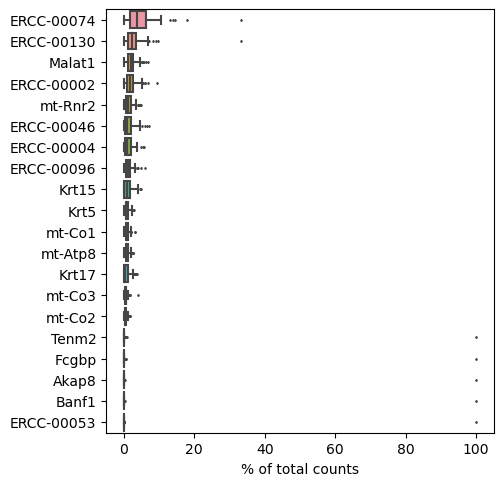

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [11]:
adata.var['mito'] = adata.var_names.str.startswith('mt-')
adata.var['hemo'] = adata.var_names.str.startswith('Hba') | adata.var_names.str.startswith('Hbb')
adata.var['ribo'] = adata.var_names.str.startswith('Rps') | adata.var_names.str.startswith('Rpl')
adata.var['ERCC'] = adata.var_names.str.startswith('ERCC')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mito', 'hemo', 'ribo', 'ERCC'], percent_top=None, log1p=False, inplace=True)

/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


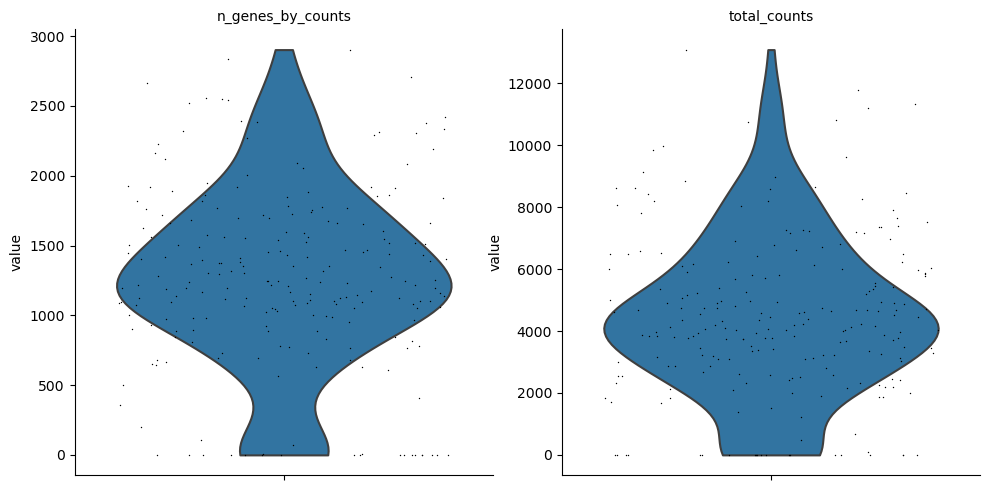

/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


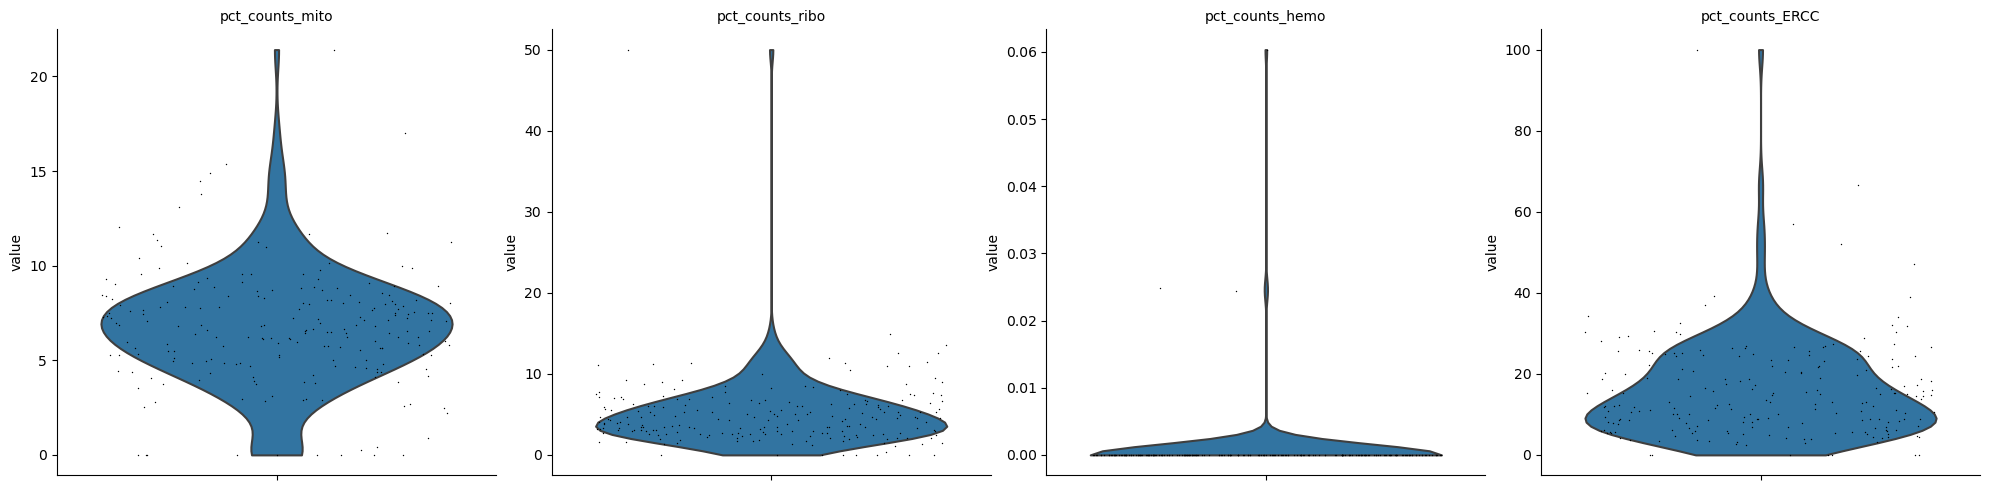

In [12]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)
sc.pl.violin(adata, ['pct_counts_mito', 'pct_counts_ribo', 'pct_counts_hemo', 'pct_counts_ERCC'],
             jitter=0.4, multi_panel=True)

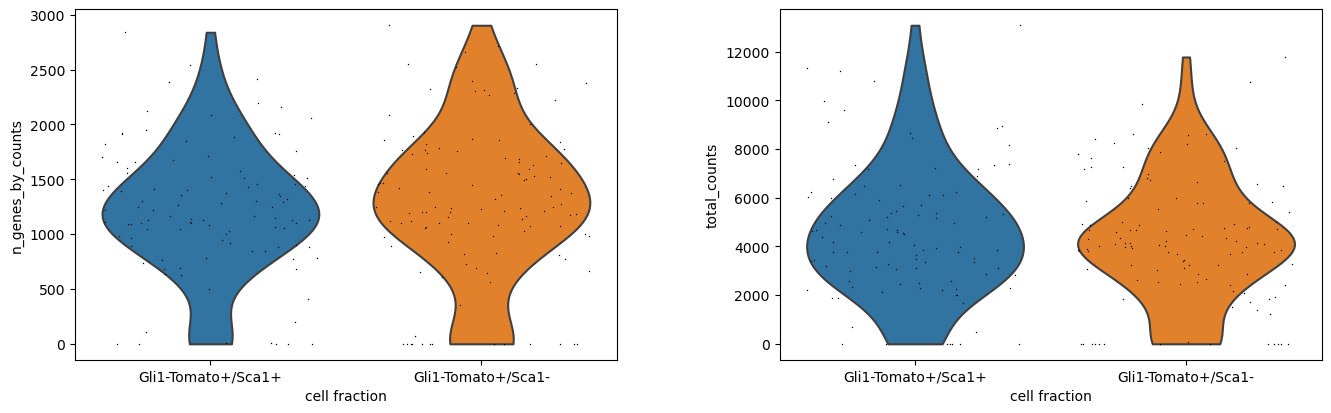

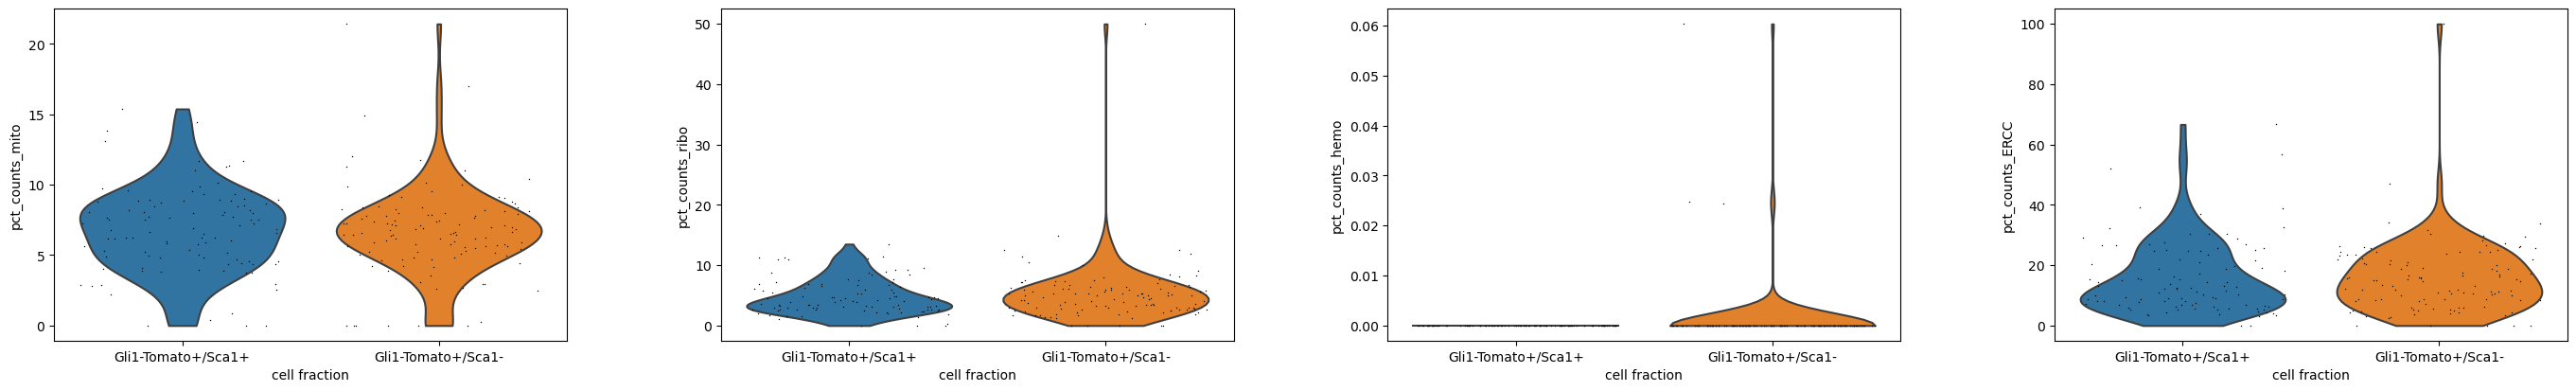

In [13]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True, groupby = 'cell_fraction')
sc.pl.violin(adata, ['pct_counts_mito', 'pct_counts_ribo', 'pct_counts_hemo', 'pct_counts_ERCC'],
             jitter=0.4, multi_panel=True, groupby = 'cell_fraction')

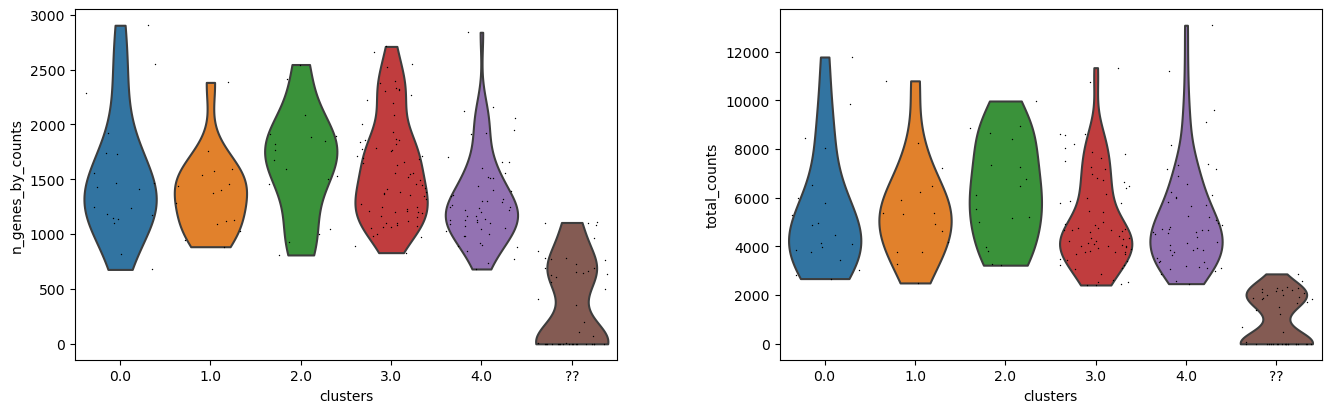

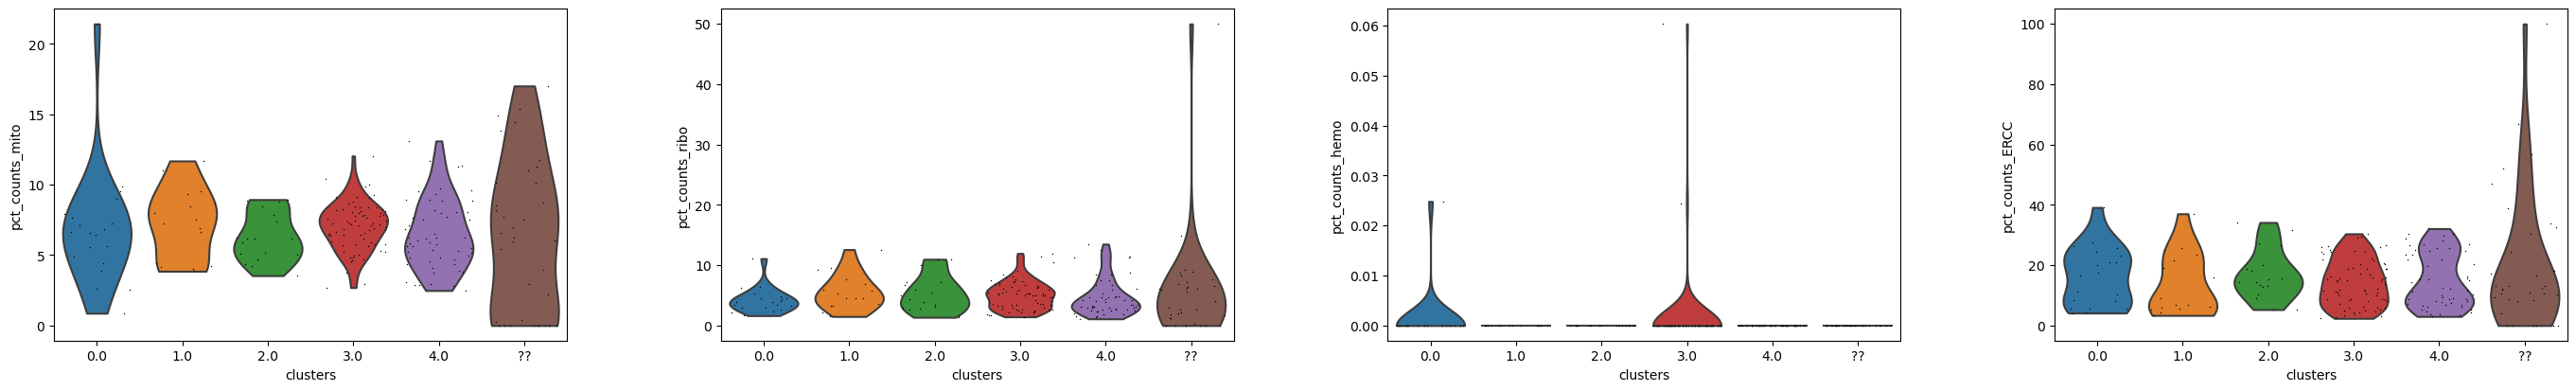

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True, groupby = 'clusters')
sc.pl.violin(adata, ['pct_counts_mito', 'pct_counts_ribo', 'pct_counts_hemo', 'pct_counts_ERCC'],
             jitter=0.4, multi_panel=True, groupby = 'clusters')

## Remove the "??" cluster - previously identified low quality cells

In [15]:
adata = adata[adata.obs['clusters']!='??'].copy()

## remove ERCC spike-ins

In [16]:
adata = adata[:, ~adata.var_names.str.startswith('ERCC')].copy()

## Normalize, HVG

In [17]:
adata.raw = sc.pp.log1p(adata, copy = True)

In [18]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

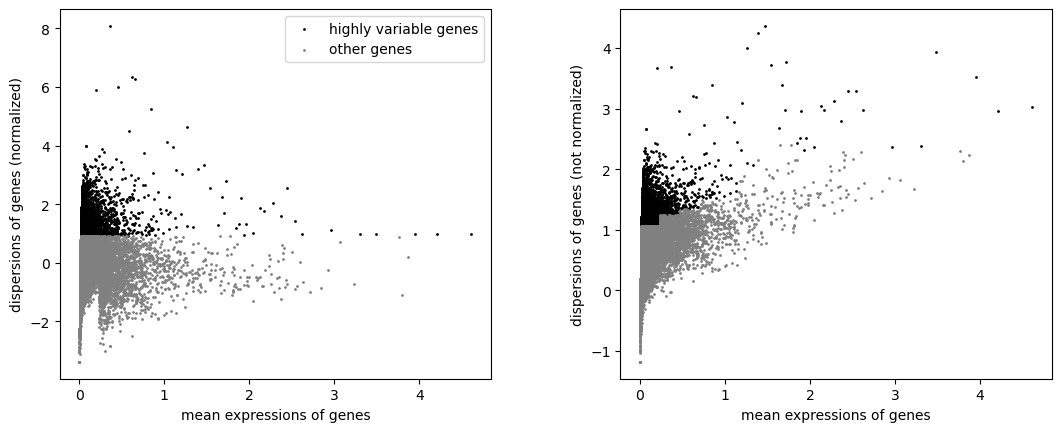

In [20]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

### Scale

In [21]:
sc.pp.scale(adata, zero_center = True)

### Cell cycle

In [22]:
sc.tl.score_genes_cell_cycle(adata, s_genes = s_genes, g2m_genes=g2m_genes)

# Dimensionality reduction

## PCA

/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


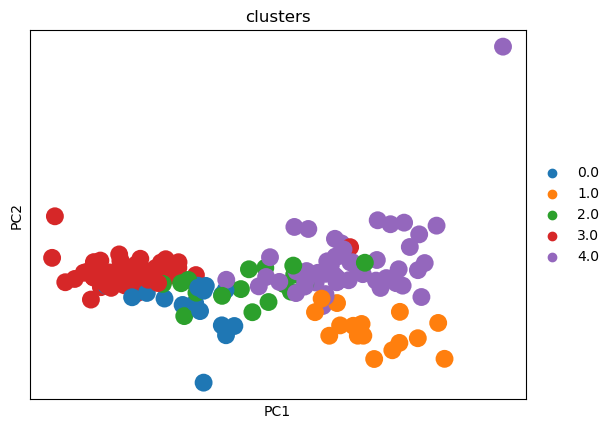

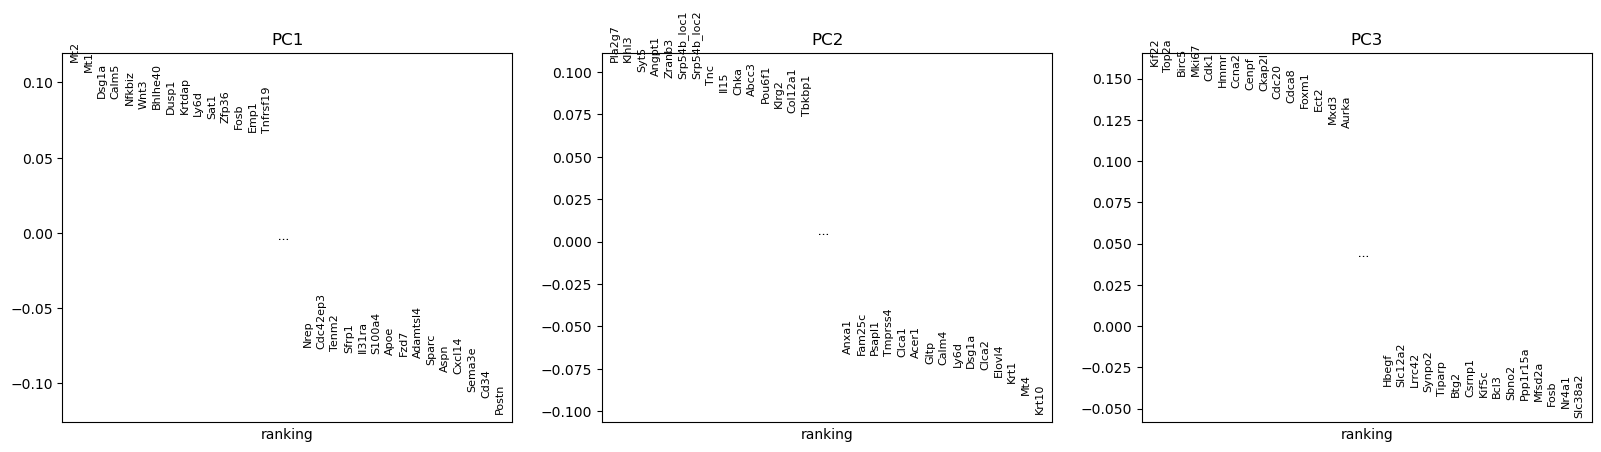

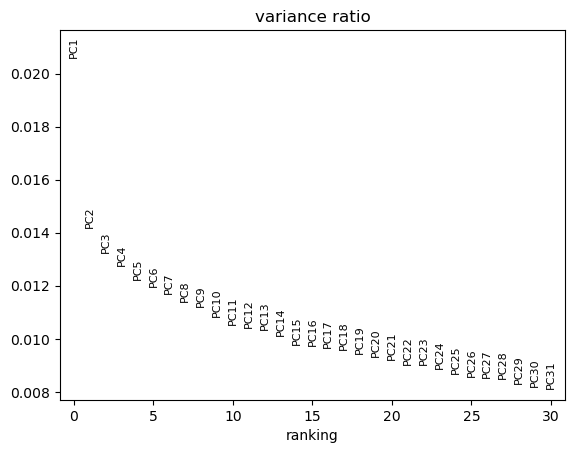

In [23]:
sc.pp.pca(adata)
sc.pl.pca_overview(adata, color = 'clusters')

## UMAP

/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


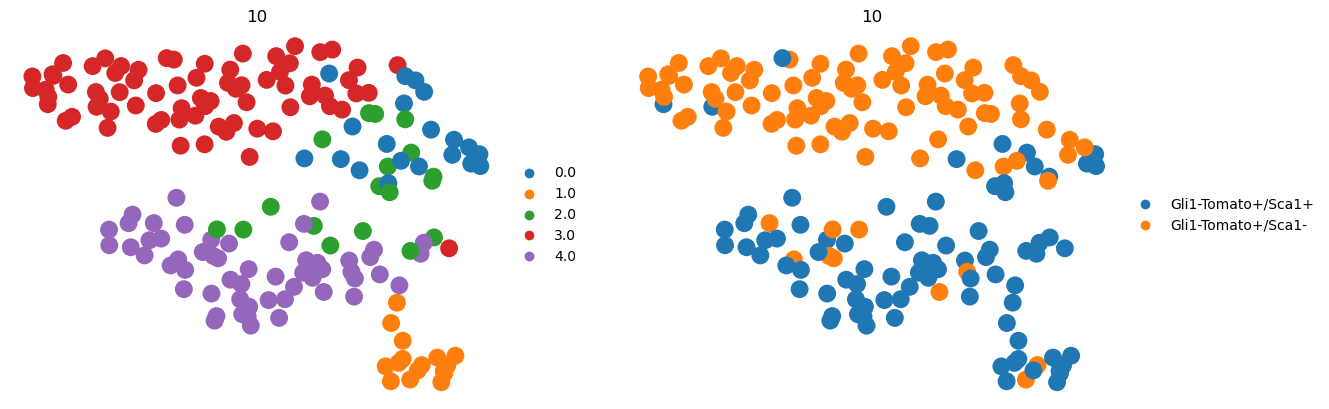

/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


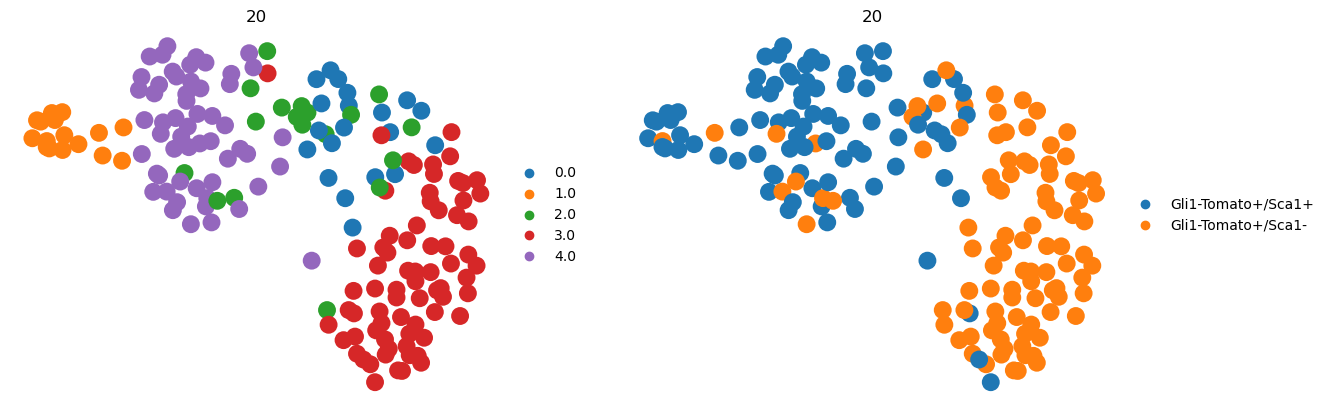

/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


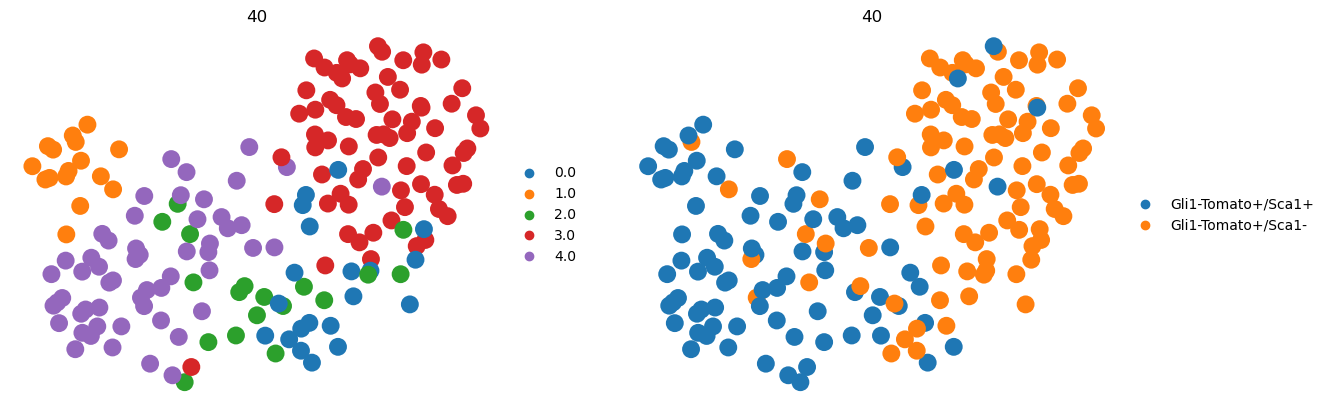

In [24]:
pcs = [10, 20, 40]
for pc in pcs:
    sc.pp.neighbors(adata, n_pcs=pc)
    sc.tl.umap(adata, spread = 1)
    sc.pl.umap(adata, color = ['clusters', 'cell_fraction'], ncols = 2, frameon = False, title = [pc, pc])

## 10 PCs

In [29]:
sc.pp.neighbors(adata, n_pcs=20)
sc.tl.umap(adata, spread = 1)

/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


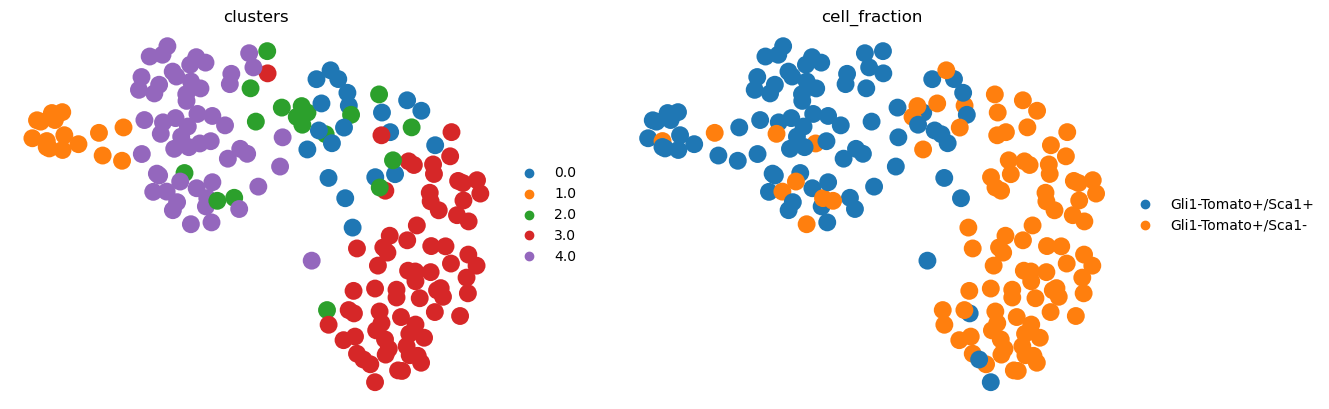

In [30]:
sc.pl.umap(adata, color = ['clusters', 'cell_fraction'], ncols = 2, frameon = False)

/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colorma

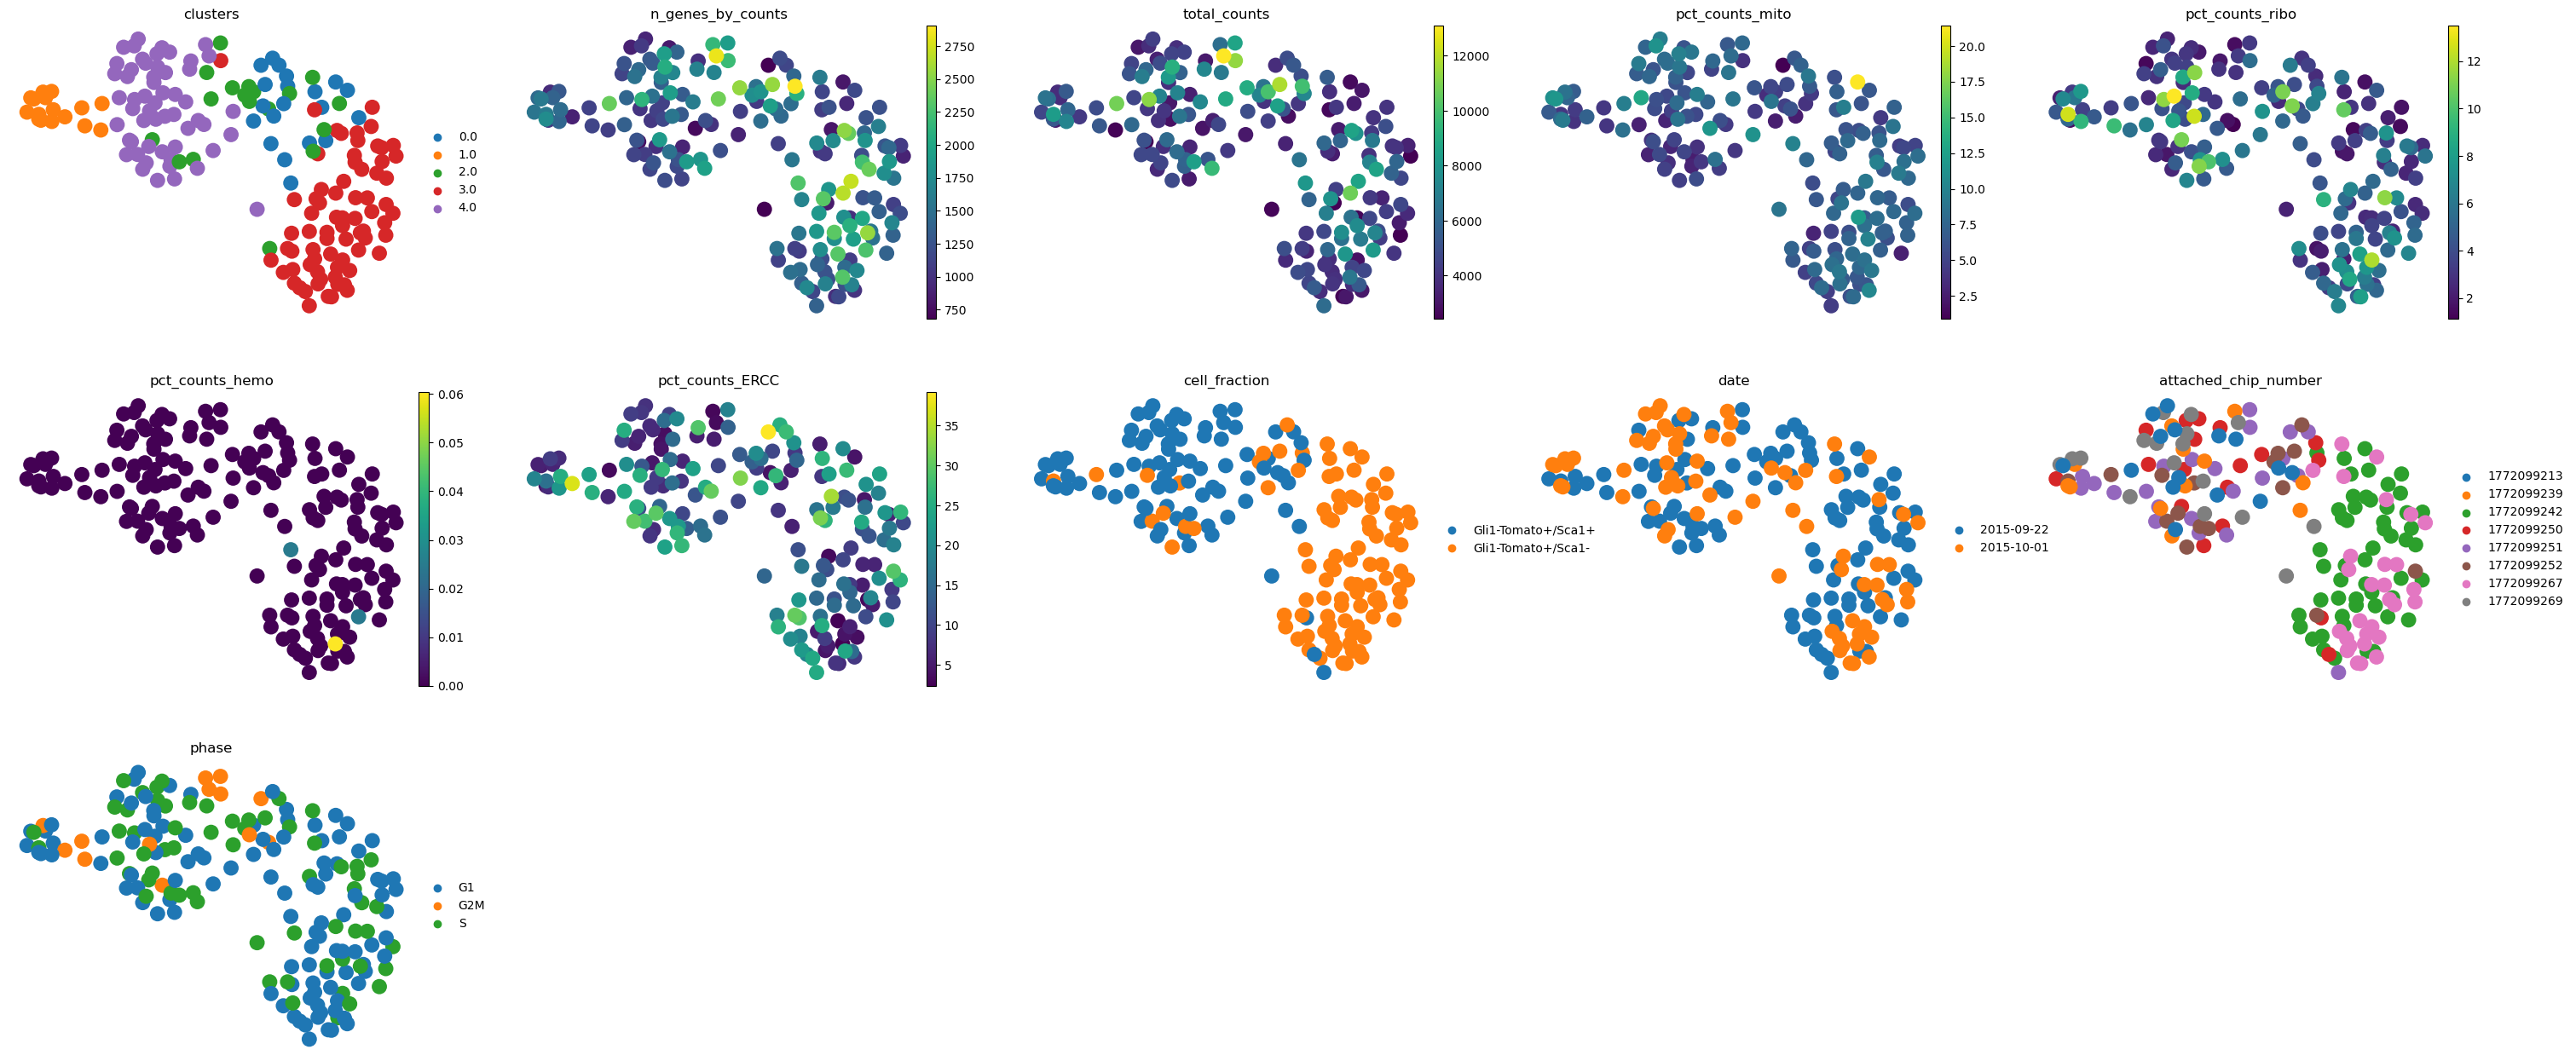

In [27]:
colors = ['clusters', 'n_genes_by_counts', 'total_counts','pct_counts_mito', 'pct_counts_ribo', 'pct_counts_hemo', 'pct_counts_ERCC', 'cell_fraction','date', 'attached_chip_number', 'phase']
sc.pl.umap(adata, color = colors, ncols = 5, frameon = False)

## leiden clusters

/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


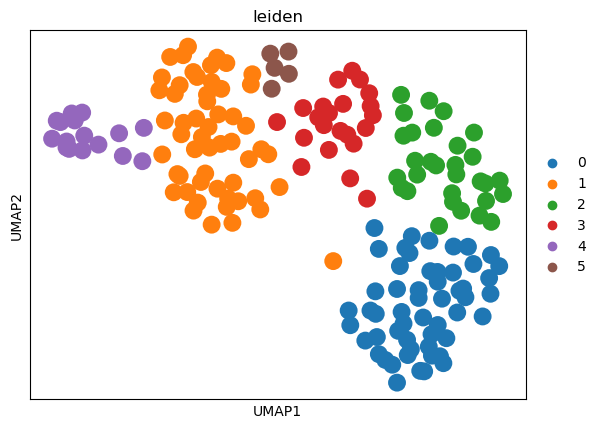

In [31]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color = 'leiden')

In [ ]:
def plot_umap_with_legends(adata, color = 'leiden', basis = 'umap', ax = None, s = 200, frameon = False, legend_fontsize = 14, legend_fontoutline = 2, side_legend = 'right margin'):
    """
    Plot umap with legends both on the side and on the clusters
    """
    if not ax:
        fig, ax = plt.subplots(figsize = (8,4))
    sc.pl.embedding(adata, basis = basis, color = color, ax = ax, show = False, s = s, frameon = frameon, legend_loc = side_legend)
    sc.pl.embedding(adata, basis = basis, color = color, ax = ax, show = False, s = 0, legend_loc = 'on data', frameon = frameon, legend_fontsize = legend_fontsize, legend_fontoutline = legend_fontoutline)            
    
def initialize_subplots(groups_to_plot, ncols = 3, figsize_multiplier = (7,5), gridspec_kw = None, figsize = None, print_help = True, **fig_kw):
    if type(groups_to_plot)==list:
        total = len(groups_to_plot)
    else:
        total = groups_to_plot
    nrows = int(np.ceil(total/ncols))
    if not figsize:
        figsize = (figsize_multiplier[0]*ncols, figsize_multiplier[1]*nrows)
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize, gridspec_kw = gridspec_kw, **fig_kw)
    if print_help:
        if nrows>1 and ncols>1:
            print('ax = axes[ix // ncols, ix % ncols]')
        else:
            print('ax = axes[ix]')
    return fig, axes

ax = axes[ix]


/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colorma

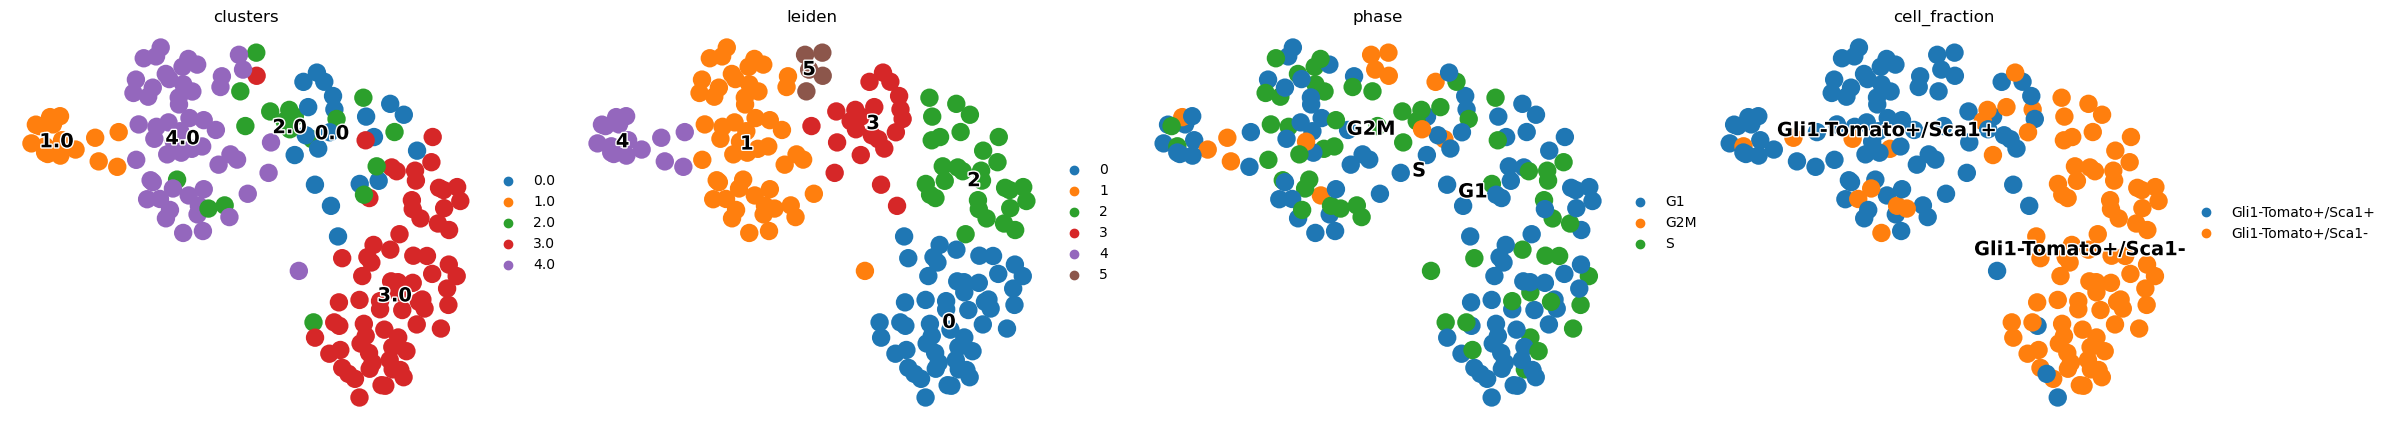

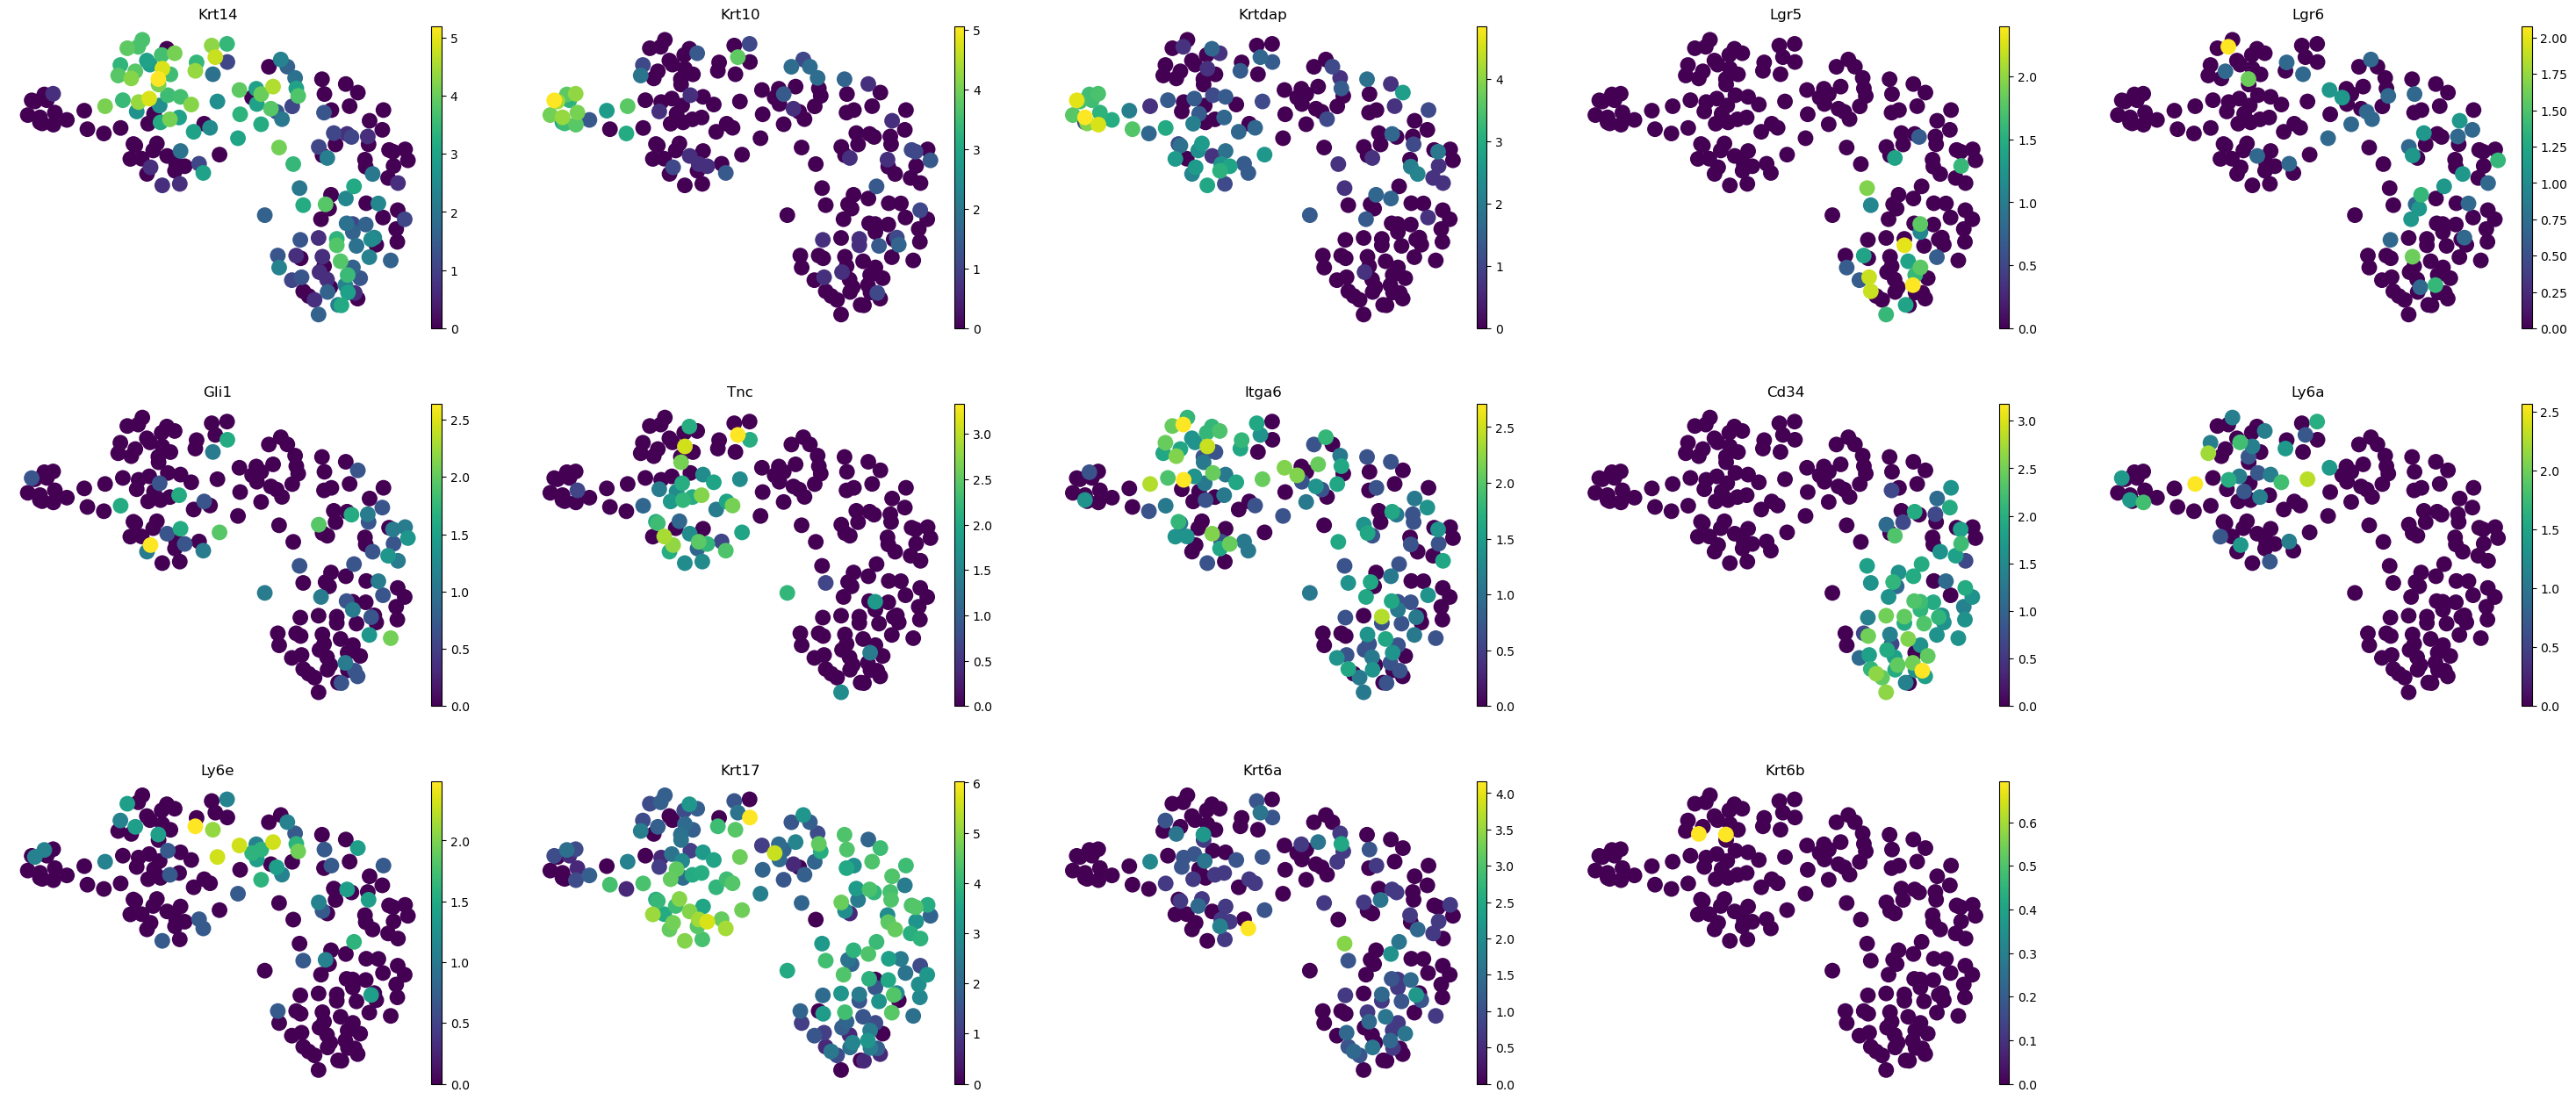

In [32]:
colors = ['clusters','leiden', 'phase','cell_fraction']
ncols = 4
fig, axes = initialize_subplots(len(colors), ncols =ncols)
for ix, c in enumerate(colors):
    ax = axes[ix]
    plot_umap_with_legends(adata, color = c, ax = ax, s = 700)
    
genes = ['Krt14', 'Krt10', 'Krtdap','Lgr5', 'Lgr6','Gli1','Tnc', 'Itga6','Cd34','Ly6a', 'Ly6e', 'Krt17','Krt6a', 'Krt6b']
sc.pl.umap(adata, color = genes, ncols = 5, frameon = False)

# Save data

In [171]:
adata.obs.columns = adata.obs.columns.str.replace('/', '-')

In [29]:
path = '/mnt/g/My Drive/MKA/Papers/Ezhkova TD_Seq'
adata = sc.read_loom(os.path.join(path, 'TD_seq_annotated.loom'), obs_names = 'obs_names')

seq = pd.read_table(os.path.join(path, '201512281816_expression_counts.txt'), index_col = 0).T
adata.raw = anndata.AnnData(X = seq)[adata.obs_names]
adata

/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 181 × 24395
    obs: 'Area', 'Blue', 'Chip serial number', 'Chip type', 'Comments', 'Date of Run', 'Diameter', 'G2M_score', 'Green', 'Operator', 'Principal Investigator', 'Protocol', 'Red', 'S_score', 'Scientist', 'Species', 'Tissue-cell type-source', 'Volume', 'age', 'attached_chip_number', 'breeder', 'cell_fraction', 'clusters', 'clusters_combined', 'clusters_named', 'comments', 'date', 'date_of_birth', 'experiment_number', 'gender', 'hair_cycle_stage', 'leiden', 'marker-CFP', 'marker-Cherry', 'marker-DsRed', 'marker-GFP', 'marker-HcRed', 'marker-Tomato', 'marker-cre', 'marker-mOrange', 'mouse_number', 'n_genes_by_counts', 'pct_counts_ERCC', 'pct_counts_hemo', 'pct_counts_mito', 'pct_counts_ribo', 'phase', 'strain', 'sum_genes', 'sum_spikes', 'sum_transcripts', 'time_of_death', 'tissue', 'total_counts', 'total_counts_ERCC', 'total_counts_hemo', 'total_counts_mito', 'total_counts_ribo', 'weight'
    var: 'ERCC', 'dispersions', 'dispersions_norm', '

# Make plots

In [30]:
cmap_TD2 = {1:'#b2182b',
            4:'#d6604d',
            2:'#f4a582',
            0:'#d1e5f0',
            3:'#4393c3',
            5:'#053061'}
adata.obs['clusters'] = adata.obs['clusters'].astype('category')
adata.uns['clusters_colors'] = [cmap_TD2[x] for x in adata.obs['clusters'].cat.categories]

In [31]:
cluster_names = {0: 'uHF',
                 1: 'Diff.',
                 2: 'Infu',
                 3: 'HF bulge',
                 4: 'TD'}

order = ['Diff.','TD','Infu','uHF','HF bulge']
adata.obs['clusters_named'] = adata.obs['clusters'].map(cluster_names)
adata.obs['clusters_named'] = adata.obs['clusters_named'].cat.reorder_categories(order)

cmap_TD = {cl: cmap_TD2[x] for x, cl in cluster_names.items()}
adata.uns['clusters_named_colors']  = [cmap_TD[x] for x in adata.obs['clusters_named'].cat.categories]

In [32]:
cmap_comb = {'IFE': '#ec1c24',
             'HF': '#00adee'}
adata.obs['clusters_combined'] = ['IFE' if cl in ['Diff.', 'TD', 'Infu'] else 'HF' for cl in adata.obs['clusters_named']]
adata.obs['clusters_combined'] = adata.obs['clusters_combined'].astype('category')
adata.uns['clusters_combined_colors'] = [cmap_comb[cl] for cl in adata.obs['clusters_combined'].cat.categories]

## Use previously identified clustering

/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


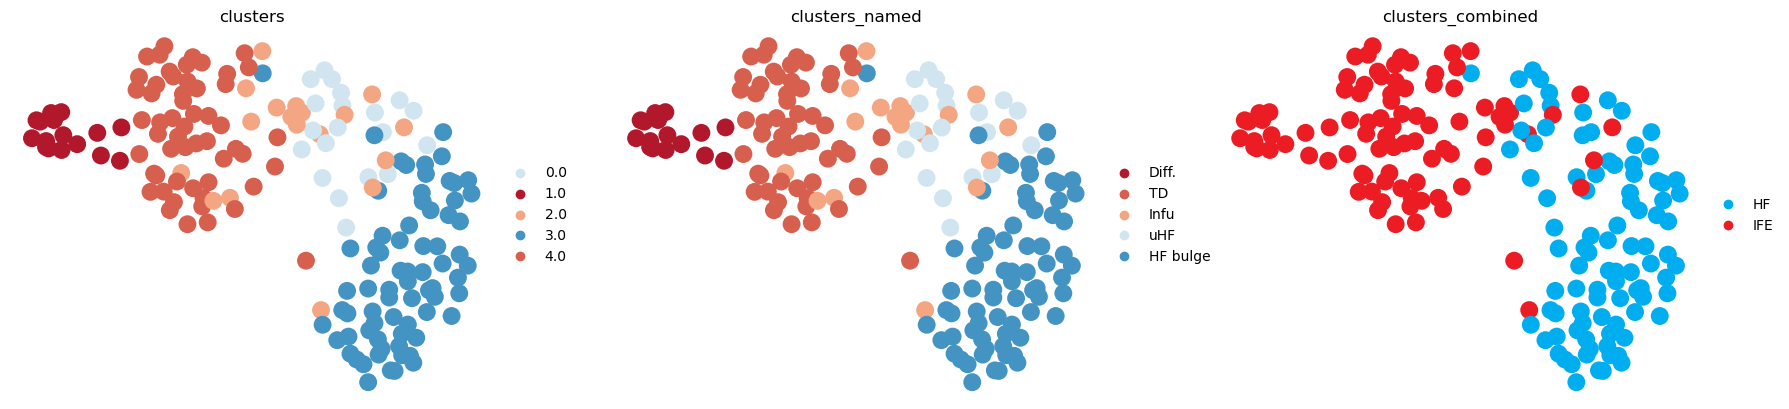

In [33]:
sc.pl.umap(adata, color = ['clusters', 'clusters_named', 'clusters_combined'], frameon = False)

ax = axes[ix]


/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


ax = axes[ix]
ax = axes[ix]


/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


ax = axes[ix]
ax = axes[ix]


/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


ax = axes[ix]


/home/karlan/miniconda3/envs/scanpy/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


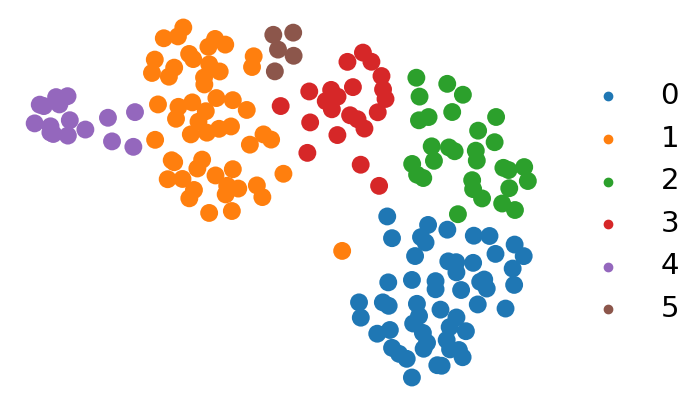

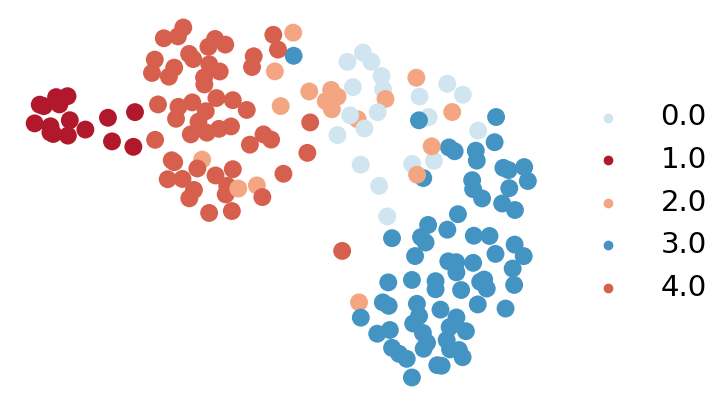

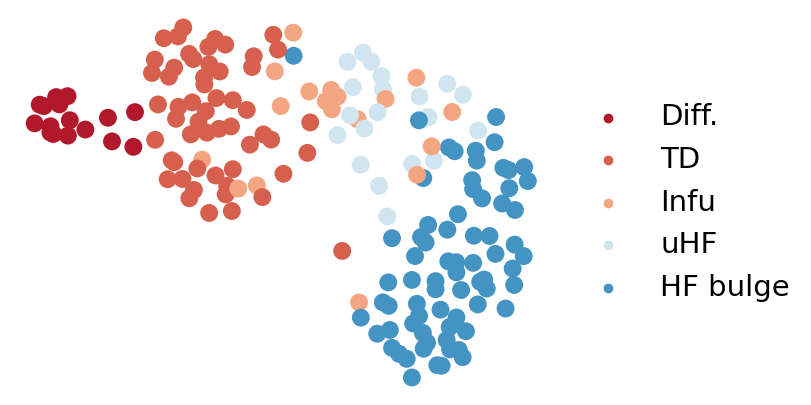

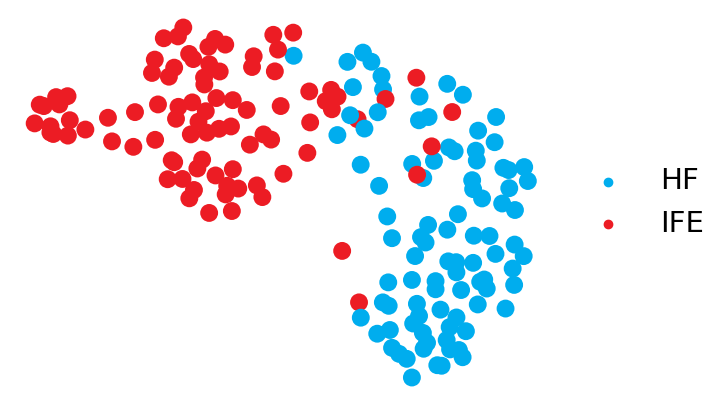

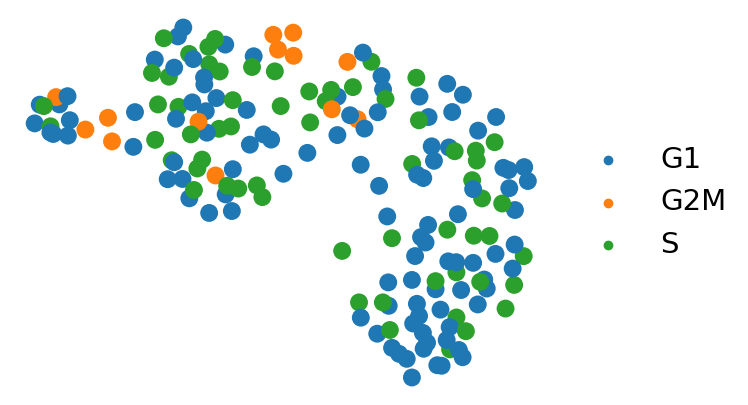

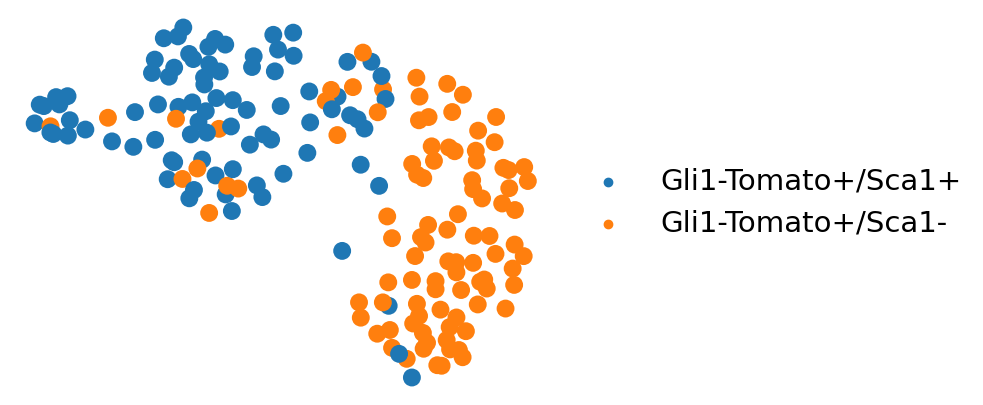

In [37]:
genes = ['leiden', 'clusters', 'clusters_named', 'clusters_combined', 'phase','cell_fraction']

for g in genes:
    fig, ax = initialize_subplots(1, ncols = 1) 
    sc.pl.umap(adata, color = g, frameon = False, show = False, ax = ax, title = '', legend_fontsize = 21)
   
    [fig.savefig(os.path.join(path, 'Figures', f'UMAP_{g}.{f}'), bbox_inches = 'tight') for f in ['png','pdf']]

ax = axes[ix // ncols, ix % ncols]


[None, None]

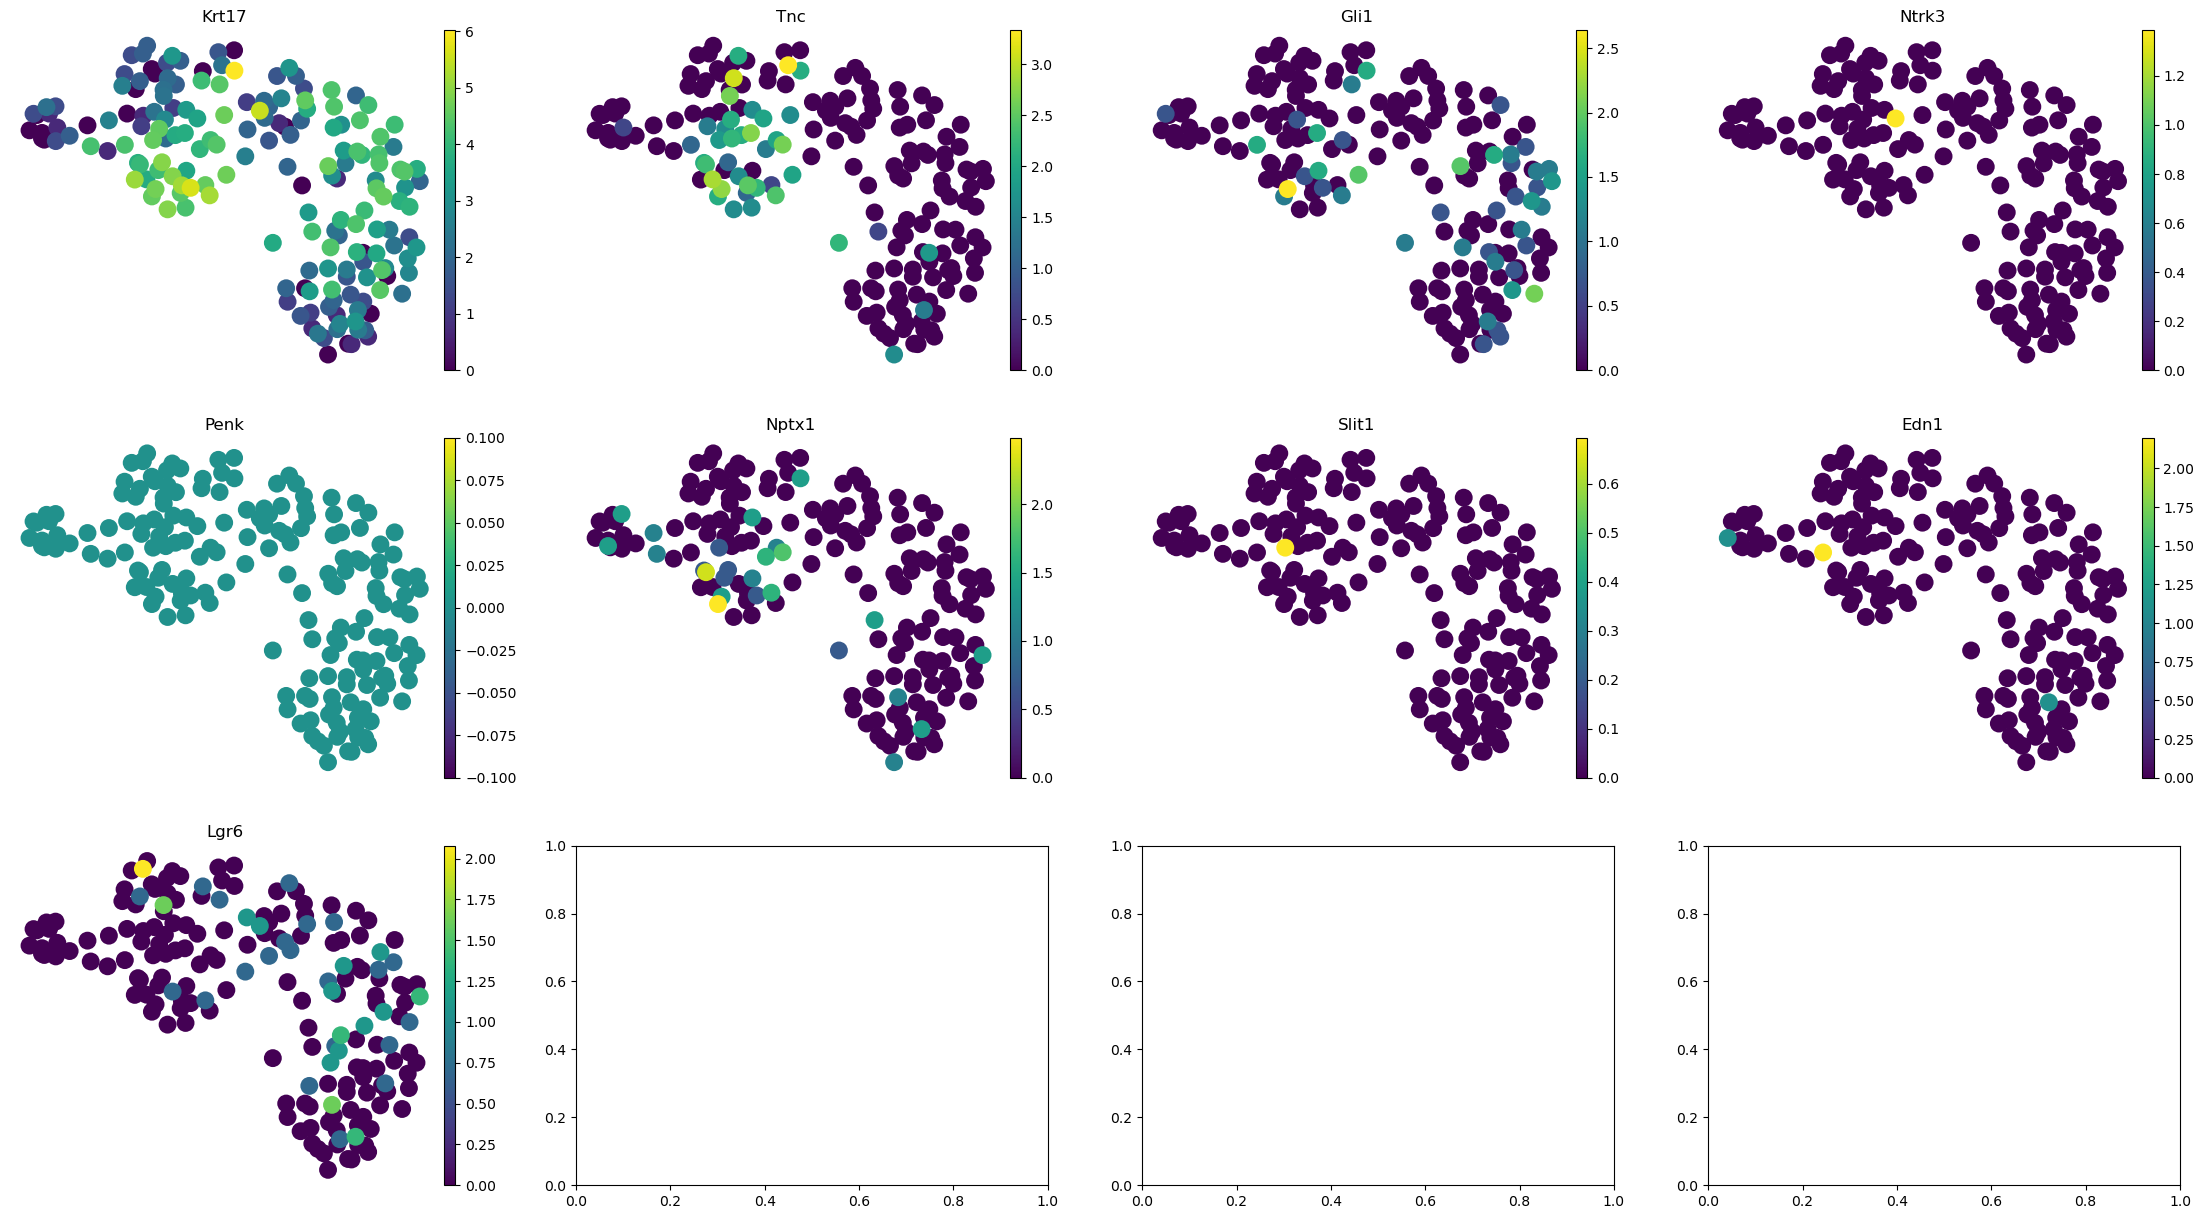

In [38]:
genes = ['Krt17','Tnc','Gli1', 'Ntrk3', 'Penk', 'Nptx1', 'Slit1', 'Edn1', 'Lgr6', 'Lhx2','Lgr5','Cd34','Fgf18']
ncols = 4

fig, axes = initialize_subplots(len(genes), ncols = ncols) 

for ix, g in enumerate(genes):
    ax = get_ax(axes, ix, ncols)
    sc.pl.umap(adata, color = g, frameon = False, show = False, ax = ax)
    
[fig.savefig(os.path.join(path, 'Figures', f'UMAP_gene_expression.{f}')) for f in ['png','pdf']]

ax = axes[ix]
ax = axes[ix]
ax = axes[ix]
ax = axes[ix]
ax = axes[ix]
ax = axes[ix]
ax = axes[ix]
ax = axes[ix]
ax = axes[ix]
ax = axes[ix]
ax = axes[ix]
ax = axes[ix]
ax = axes[ix]


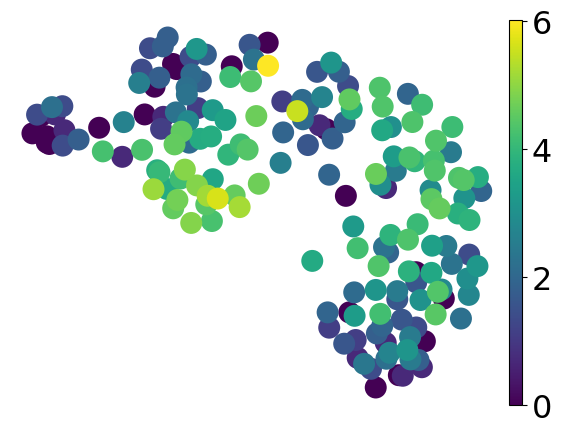

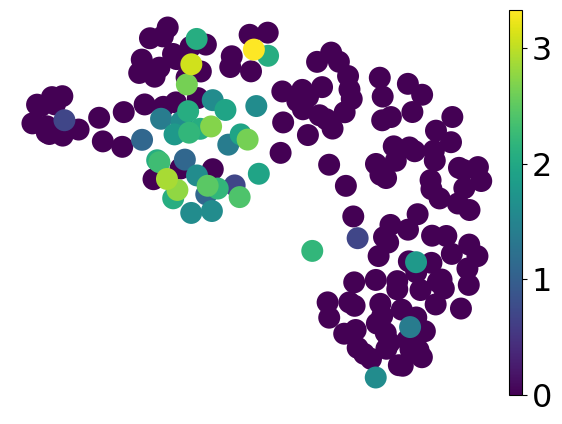

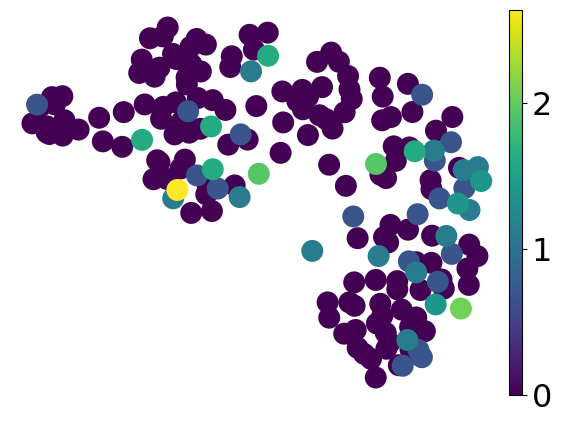

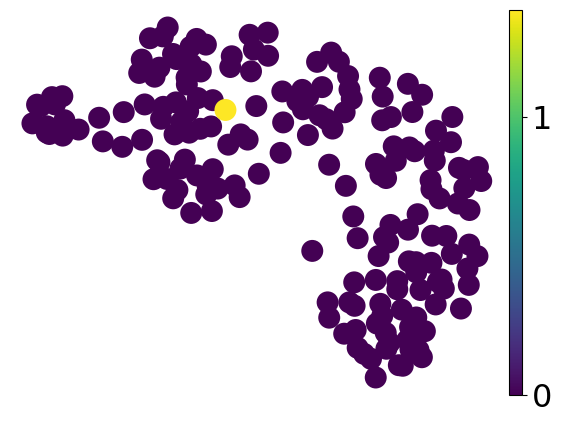

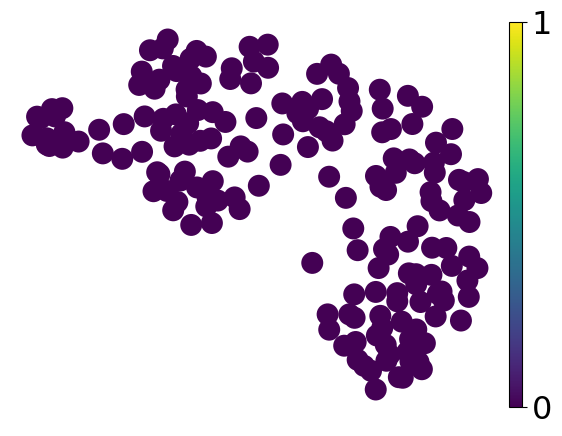

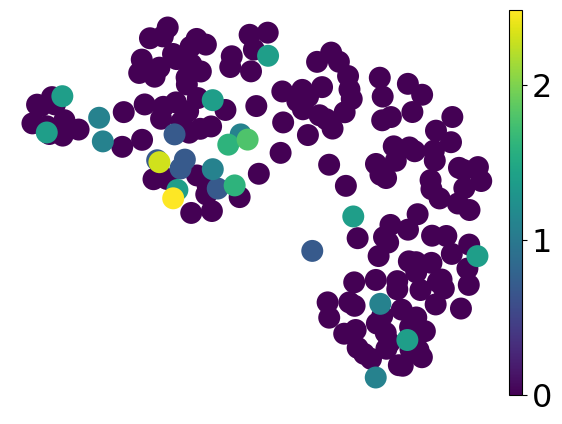

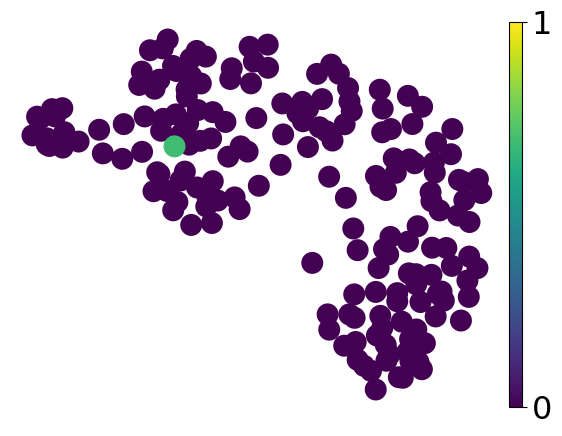

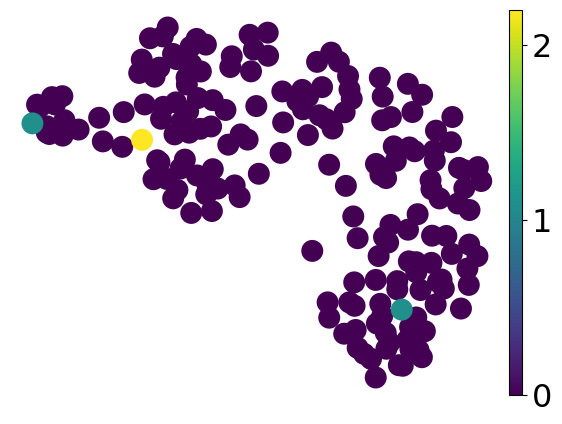

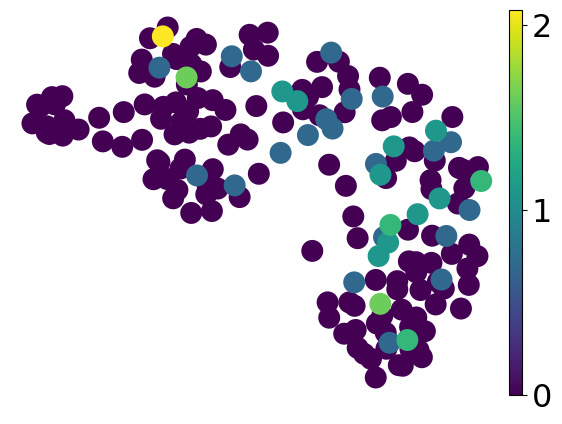

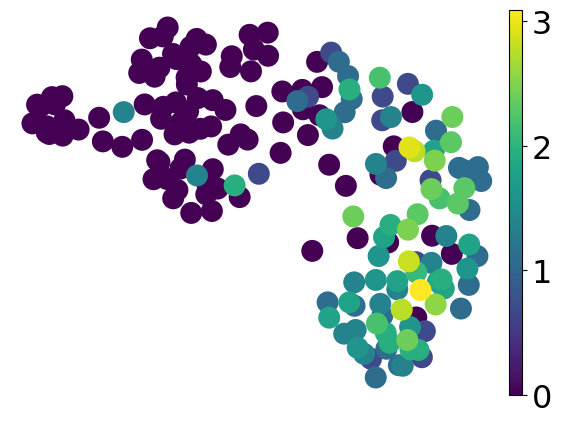

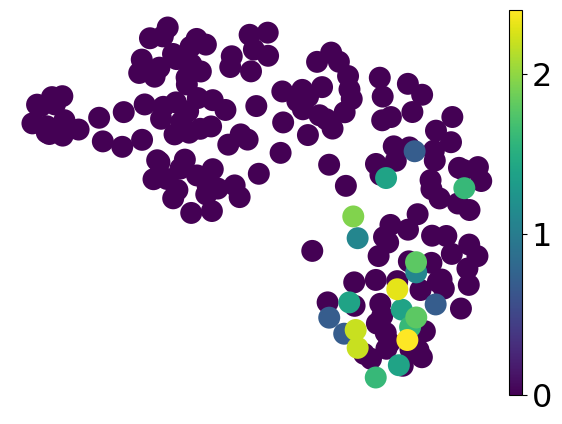

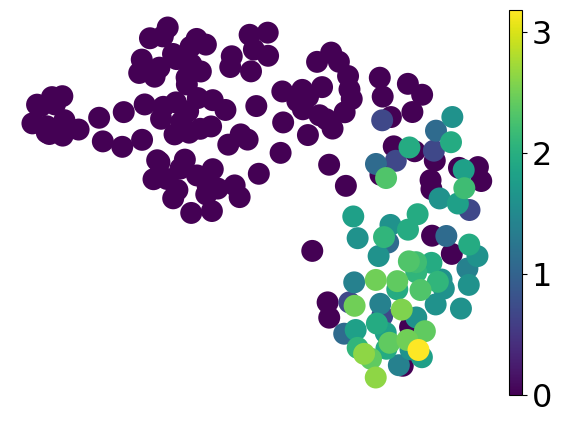

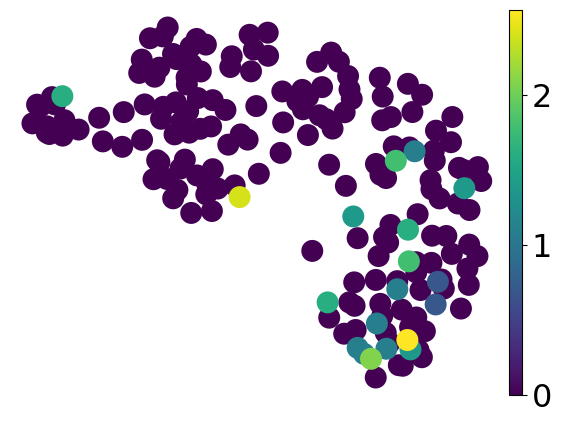

In [153]:
genes = ['Krt17','Tnc','Gli1', 'Ntrk3', 'Penk', 'Nptx1', 'Slit1', 'Edn1', 'Lgr6', 'Lhx2','Lgr5','Cd34','Fgf18']

for g in genes:
    fig, ax = initialize_subplots(1, ncols = 1) 
    sc.pl.umap(adata, color = g, frameon = False, show = False, ax = ax, title = '', vmin = 0, s = 1000, vmax = 1 if g in ['Penk', 'Slit1'] else None)
    ax.set_title('', fontsize = 26)
    cbar = ax.collections[0].colorbar
    cbar.set_ticks(MaxNLocator(integer = True, nbins = 4))
    cbar.ax.tick_params(labelsize=23)
    [fig.savefig(os.path.join(path, 'Figures', f'UMAP_{g}.{f}')) for f in ['png','pdf']]

[None, None]

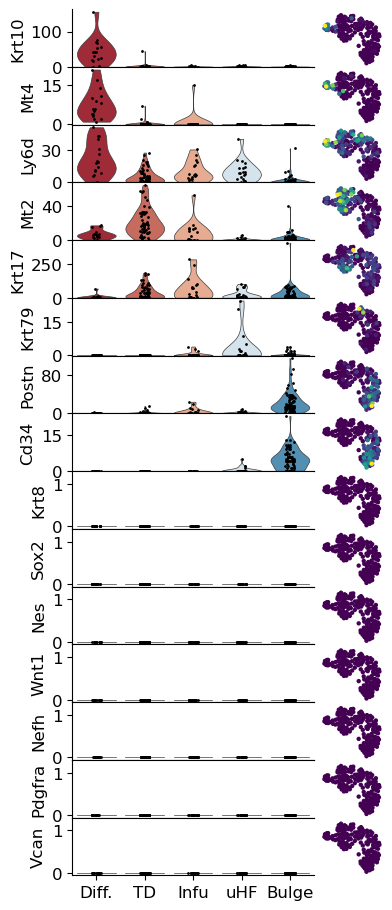

In [83]:
#genes = ['Krt10','Mt4','Ly6d','Mt2', 'Krt17','Krt79','Defb6','Aspn','Nrep','Postn','Cd34']
genes = ['Krt10','Mt4','Ly6d','Mt2','Krt17','Krt79','Postn','Cd34', 'Krt8', 'Sox2','Nes','Wnt1','Nefh','Pdgfra','Vcan']
cl = 'clusters_named'
fontsize = 12

df = pd.DataFrame(data = adata.raw[:, genes].X, index = adata.obs_names, columns = genes)
df = adata.obs.join(df)

fig, axes = plt.subplots(ncols = 2, nrows = len(genes), figsize = (4, 0.75*len(genes)), sharex = 'col', 
                         gridspec_kw = {'hspace': 0, 'width_ratios': [4, 1], 'wspace': 0.05})

for ix, g in enumerate(genes):
    ax = axes[ix, 0]
    sbn.violinplot(data = df, x = cl, y = g, ax = ax, cut = 0, scale = 'width', inner = None, palette = cmap_TD, linewidth = 0.5)
    sbn.stripplot(data = df, x = cl, y = g, ax = ax, c = 'k', s = 2)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True, nbins = 2, prune = 'both'))
    
    [ax.spines[spine].set_visible(False) for spine in (['top', 'right'] if ix == 0 else ['right'])]
    ax.set_ylabel(ax.get_ylabel(), fontsize = fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    y_bottom, y_top = ax.get_ylim()
    if y_bottom < -0.06:
        ax.set_ylim(bottom = -0.1)
    if y_top < 1:
        ax.set_ylim(top = 1.3)
    
    ax = axes[ix, 1]
    sc.pl.umap(adata, color = g, frameon = False, ax = ax, show = False, s = 40, vmax = 1 if y_top < 1 else None)
    ax.collections[-1].colorbar.remove()
    ax.set_title('')
    ylim = ax.get_ylim()
    xlim = ax.get_xlim()
    #ax.set_xlim([xlim[0]-xlim[0]*0.1, xlim[1]+xlim[1]*0.1])
    ax.set_ylim([ylim[0]-ylim[0]*0.05, ylim[1]+ylim[1]*0.05])
    
ax = axes[-1, 0]
#ax.set_ylim(bottom = -0.1, top = 1.5)
    
ax.set_xlabel('')
labels = ax.get_xticklabels()
labels[-1].set_text('Bulge')
ax.set_xticklabels(labels, rotation = 0, fontsize = fontsize)

[fig.savefig(os.path.join(path, 'Figures', f'Violinplot_UMAP_fib-markers.{f}'), bbox_inches = 'tight') for f in ['pdf', 'png']]